# Bagging-based estimator

In [1]:
# temporary fix to avoid spurious warning raised in scikit-learn 1.0.0
# it will be solved in scikit-learn 1.0.1
import warnings
warnings.filterwarnings("ignore", message="X has feature names.*")
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

## Bagging estimator

We saw that by increasing the depth of the tree, we are going to get an over-fitted model. A way to bypass the choice of a specific depth it to combine several trees together.

Let's start by training several trees on slightly different data. The slightly different dataset could be generated by randomly sampling with replacement. In statistics, this called a boostrap sample. We will use the iris dataset to create such ensemble and ensure that we have some data for training and some left out data for testing.

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X, y = X[:100], y[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Before to train several decision trees, we will run a single tree. However, instead to train this tree on `X_train`, we want to train it on a bootstrap sample. You can use the `np.random.choice` function sample with replacement some index. You will need to create a sample_weight vector and pass it to the `fit` method of the `DecisionTreeClassifier`. We provide the `generate_sample_weight` function which will generate the `sample_weight` array.

In [3]:
import numpy as np

def bootstrap_idx(X):
    indices = np.random.choice(
        np.arange(X.shape[0]), size=X.shape[0], replace=True
    )
    return indices

In [4]:
bootstrap_idx(X_train)

array([33, 38, 59, 11, 48, 60,  3, 29, 73, 37, 51, 26, 48, 56, 20, 72, 54,
       69, 33, 40, 53, 57, 50,  0, 18, 48, 51,  1, 13, 17, 38, 20, 73, 27,
       51, 28, 41, 56, 58, 57, 74, 64, 66,  5, 60, 22, 34, 59, 40, 10, 28,
       27,  9, 14, 12,  7, 42, 30, 69, 73, 68, 18, 51, 73, 31, 12, 50, 66,
       38,  4, 61, 53, 65, 30, 69])

In [5]:
from collections import Counter
Counter(bootstrap_idx(X_train))

Counter({40: 3,
         42: 2,
         34: 2,
         13: 3,
         56: 1,
         50: 3,
         9: 3,
         54: 4,
         71: 1,
         8: 3,
         44: 2,
         58: 2,
         30: 1,
         60: 2,
         26: 1,
         32: 1,
         45: 1,
         23: 1,
         28: 1,
         47: 2,
         11: 2,
         37: 1,
         14: 2,
         64: 2,
         31: 2,
         66: 1,
         39: 2,
         52: 1,
         65: 1,
         53: 1,
         5: 2,
         57: 1,
         43: 1,
         24: 2,
         36: 1,
         3: 2,
         69: 1,
         55: 1,
         4: 2,
         41: 1,
         18: 1,
         16: 2,
         6: 1,
         62: 1,
         73: 1,
         20: 1})

In [6]:
def bootstrap_sample(X, y):
    indices = bootstrap_idx(X)
    return X[indices], y[indices]

In [7]:
X_train_bootstrap, y_train_bootstrap = bootstrap_sample(X_train, y_train)

In [8]:
print(f'Classes distribution in the original data: {Counter(y_train)}')
print(f'Classes distribution in the bootstrap: {Counter(y_train_bootstrap)}')

Classes distribution in the original data: Counter({1: 38, 0: 37})
Classes distribution in the bootstrap: Counter({0: 42, 1: 33})


<div class="alert alert-success">
    <b>EXERCISE: Create a bagging classifier</b>:
    <br>
    A bagging classifier will train several decision tree classifiers, each of them on a different bootstrap sample.
     <ul>
      <li>
          Create several <tt>DecisionTreeClassifier</tt> and store them in a Python list;
      </li>
      <li>
          Loop over these trees and <tt>fit</tt> them by generating a bootstrap sample using <tt>bootstrap_sample</tt> function;
      </li>
      <li>
          To predict with this ensemble of trees on new data (testing set), you can provide the same set to each tree and call the <tt>predict</tt> method. Aggregate all predictions in a NumPy array;
      </li>
      <li>
          Once the predictions available, you need to provide a single prediction: you can retain the class which was the most predicted which is called a majority vote;
      </li>
      <li>
          Finally, check the accuracy of your model.
      </li>
    </ul>
</div>

<div class="alert alert-success">
    <b>EXERCISE: using scikit-learn</b>:
    <br>
    After implementing your own bagging classifier, use a `BaggingClassifier` from scikit-learn to fit the above data.
</div>

### Note regarding the base estimator

In the previous section, we used decision tree as a base estimator in the bagging ensemble. However, this method can accept any kind of base estimator. We will compare two bagging models: one that uses decision tree and another that uses a linear model with a preprocessing step.

Let's first create a synthetic regression dataset.

In [10]:
import pandas as pd

#create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)

n_samples = 30
x_min, x_max = -3, 3
x = rng.uniform(x_min, x_max, size=n_samples)
noise = 4.0 * rng.randn(n_samples)
y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
y /= y.std()

data_train = pd.DataFrame(x, columns=["Feature"])
data_test = pd.DataFrame(
    np.linspace(x_max, x_min, num=300), columns=["Feature"])
target_train = pd.Series(y, name="Target")


In [11]:
import seaborn as sns
sns.set_context("poster")

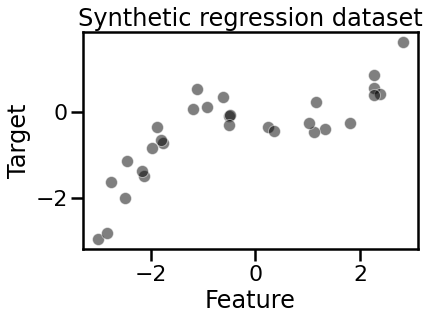

In [15]:
ax = sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black",
    alpha=0.5
)
_ = ax.set_title("Synthetic regression dataset")

We will first train a `BaggingRegressor` where the based estimator are `DecisionTreeRegressor`.

In [16]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(n_estimators=50, random_state=0)
bagged_trees.fit(data_train, target_train)

BaggingRegressor(n_estimators=50, random_state=0)

We can make a plot where will show the prediction given by each individual trees and the averaged response given by the baggin regressor.

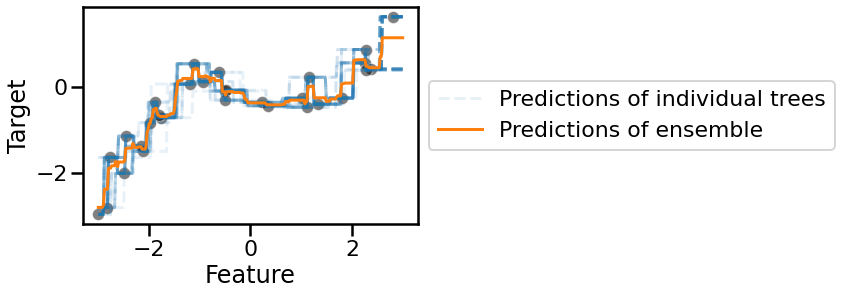

In [18]:
import matplotlib.pyplot as plt

for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Now, we will show that we can use a model other than a decision tree. Indeed, we will create a model that will use a `PolynomialFeatures` to augment features followed by a linear model that is `Ridge`.

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

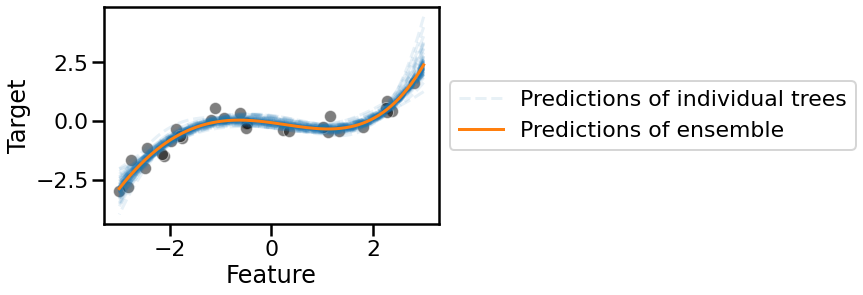

In [20]:
bagged_trees = BaggingRegressor(
    n_estimators=100, base_estimator=polynomial_regressor, random_state=0
)
bagged_trees.fit(data_train, target_train)

for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

We can observe that both base estimators can be used to model our toy example.

## Random Forests

### Random forest classifier

A very famous classifier is the random forest classifier. It is similar to the bagging classifier. In addition of the bootstrap, the random forest will use a subset of features (selected randomly) to find the best split.

<div class="alert alert-success">
    <b>EXERCISE: Create a random forest classifier</b>:
    <br>
    Use your previous code which was generated several <tt>DecisionTreeClassifier</tt>. Check the list of the option of this classifier and modify one of the parameters such that only the $\sqrt{F}$ features are used for the splitting. $F$ represents the number of features in the dataset.
</div>

<div class="alert alert-success">
    <b>EXERCISE: using scikit-learn</b>:
    <br>
    After implementing your own random forest classifier, use a <tt>RandomForestClassifier</tt> from scikit-learn to fit the above data.
</div>

### Random forest regressor

<div class="alert alert-success">
    <b>EXERCISE</b>:
    <br>
    <ul>
        <li>Load the datasets available in <tt>sklearn.datasets.fetch_california_housing</tt>.</li>
        <li>Fit a <tt>RandomForestRegressor</tt> with the default parameters.</li>
        <li>What is the number of features used during the training process?</li>
        <li>What is the difference between an <tt>BaggingRegressor</tt> and a <tt>RandomForestRegressor</tt>?</li>
    </ul>
</div>

In [22]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [23]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [25]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.7928689819806595

### Hyperparameters

The hyperparameters having an impact on the training process will mainly be the same than for the decision tree. One can look at the documentation. However, since we are dealing with a forest of trees, there is a new parameter `n_estmators`. We can quickly make an exercise to check the effect of modifying this parameter. For this matter, we will use a validation curve.

In [28]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

<div class="alert alert-success">
    <b>EXERCISE</b>:
    <br>
    <ul>
        <li>Use the <tt>sklearn.model_selection.validation_curve</tt> to compute the train and test scores and thus analyse the impact of the `n_estimators` parameter. You will have to define a range of values for this parameter.</li>
        <li>Plot the train and test scores as well as the confidence intervals.</li>
    </ul>
    What is the impact of increasing the number of trees in the ensemble in terms of statistical performance? Do you think that there is a trade-off with the computational performance?
</div>

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)

In [44]:
from sklearn.model_selection import validation_curve

param_name = "n_estimators"
param_range = np.unique(np.logspace(0, 2, num=10).astype(np.int64))
train_scores, test_scores = validation_curve(
    model, X, y, param_name=param_name, param_range=param_range
)

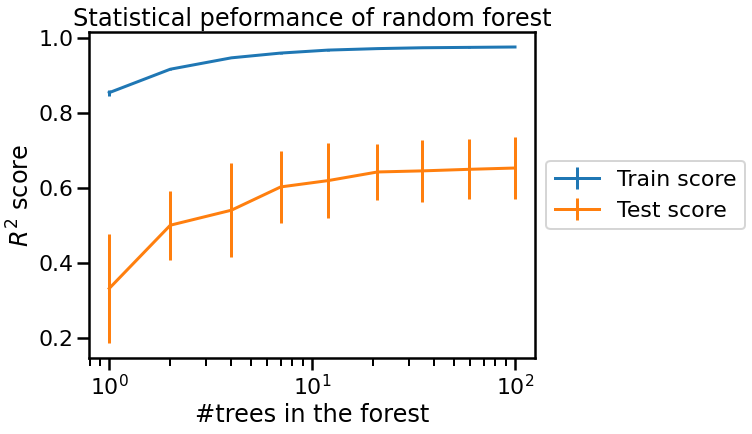

In [53]:
_, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    x=param_range,
    y=train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    label="Train score",
)
ax.errorbar(
    x=param_range,
    y=test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    label="Test score",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xscale("log")
ax.set_xlabel("#trees in the forest")
ax.set_ylabel("$R^2#$ score")
_ = ax.set_title("Statistical peformance of random forest")

The other parameters controlling the tree individual trees overfitting could also be tuned. Sometimes, there is no need to have fully grown trees. However, be aware that with random forest, trees are generally deep since we are seeking to overfit the learners on the bootstrap samples because this will be mitigated by combining them. Assembling underfitted trees (i.e. shallow trees) might also lead to an underfitted forest.